# Experiment: Piecewise-linear approximation of VNF-PPs (Analysis)

Try to represent VNF-PPs as piece-wise linear functions.
The fitting is done using the [pwlf Python library](https://pypi.org/project/pwlf/).

Cite PWLF:

```latex
@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}
```

## Segment number optimization

* Bayesian Optimization using [GPyOpt](https://sheffieldml.github.io/GPyOpt/)

```
@Misc{gpyopt2016,
  author =   {The GPyOpt authors},
  title =    {GPyOpt: A Bayesian Optimization framework in Python},
  howpublished = {\url{http://github.com/SheffieldML/GPyOpt}},
  year = {2016}
}
```

In [1]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import random
random.seed(12121)
np.random.seed(12121)
import pwlf
from sklearn import metrics as em
from GPyOpt.methods import BayesianOptimization

## Data Management
Load and clean the data sets to be easily used.

### Load data sets

In [2]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/smallFlows.pcap", "0")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/bigFlows.pcap", "1")
    _to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "1")
    _replace(df, "ruleset", "./start.sh big_ruleset", "2")
    _replace(df, "ruleset", "./start.sh", "0")
    _to_num(df, "ruleset")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "1")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "1")
    _to_num(df, "req_size")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json", "0")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json", "1")
    _replace(df, "req_type", "malaria publish -s 10 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "2")
    _replace(df, "req_type", "malaria publish -s 10000 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "3")
    _to_num(df, "req_type")
    
df_sec01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec01/data/csv_experiments.csv")
df_sec02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec02/data/csv_experiments.csv")
df_sec03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec03/data/csv_experiments.csv")
df_web01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web01/data/csv_experiments.csv")
df_web02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web02/data/csv_experiments.csv")
df_web03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web03/data/csv_experiments.csv")
df_iot01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot01/data/csv_experiments.csv")
df_iot02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot02/data/csv_experiments.csv")

# do renaming and selection
map_sec01 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__suricata_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__suricata_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec02 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort2.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort2.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort2.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__snort_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__snort_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__snort_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__snort_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec03 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort3.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort3.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort3.0.1__mem_max": "memory",
    #"metric__vnf0.vdu01.0__snort3_total_allow": "ids_allow",
    "metric__vnf0.vdu01.0__snort3_total_analyzed": "ids_pkts",
    "metric__vnf0.vdu01.0__snort3_total_received": "ids_recv",
    #"metric__vnf0.vdu01.0__snort3_total_outstanding": "ids_outstanding",
    "metric__vnf0.vdu01.0__snort3_total_dropped": "ids_drop",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web01 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-nginx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-nginx.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web02 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-haproxy.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-haproxy.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web03 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.px-squid.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.px-squid.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot01 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-mosquitto.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-mosquitto.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot02 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-emqx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-emqx.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
    

}

# add additional data
df_sec01["vnf"] = "suricata"
df_sec02["vnf"] = "snort2"
df_sec03["vnf"] = "snort3"
df_web01["vnf"] = "nginx"
df_web02["vnf"] = "haproxy"
df_web03["vnf"] = "squid"
df_iot01["vnf"] = "mosquitto"
df_iot02["vnf"] = "emqx"


# cleanup data sets
dfs_raw = [df_sec01, df_sec02, df_sec03, df_web01, df_web02, df_web03, df_iot01, df_iot02]
map_list = [map_sec01, map_sec02, map_sec03, map_web01, map_web02, map_web03, map_iot01, map_iot02]
dfs = list()  # clean data frames

for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)

In [3]:
dfs[3].head()

,req_size,cpu_bw,memory,req_compl,req_per_sec,transf_bytes,if_rx_bytes,if_tx_bytes
0,0,0.1,64,104196.0,1733.25,31838613.0,18412200.0,39004587.0
1,0,0.1,64,105190.0,1747.06,32142337.0,18587678.0,39376437.0
2,0,0.1,64,103188.0,1710.96,31530605.0,18233626.0,38627397.0
3,0,0.1,64,103718.0,1717.78,31692564.0,18327338.0,38825497.0
4,0,0.1,64,100496.0,1656.68,30707997.0,17758410.0,37619913.0


### Polish data

In [4]:
#df = dfs[0].copy()
#df = df[(df["flow_size"]==0) & (df["ruleset"]==2) & (df["memory"]==256)]
#df = df.groupby("cpu_bw").mean()
#df.head()
#dfs[1][dfs[1]["ids_pkts"].isnull()]

## PWLF Prototype

More advanced PWLF implementation to be used with generic data sets.

In [5]:
MAX_SEG = 13

In [6]:
class MyPWLF(object):
    """
    Wrapper around PWLF to also fit functions with only one
    segment by using a trick that creates a first segment that is
    virtually 0.
    """
    def __init__(self, data, x_col, y_col, degree=1):
        # ensure we work on fresh data
        data = data.copy()
        # ensure that we drop the NaN from the data
        data.dropna(subset=[x_col, y_col], inplace=True)
        # get the data
        self.xin = np.array(data[x_col])
        self.yin = np.array(data[y_col])
        assert(len(self.xin) == len(self.yin))
        # PWLF Model
        self.pwlf_obj = pwlf.PiecewiseLinFit(self.xin, self.yin, degree=degree)       
        
    def fit(self, nseg, fast=True):
        if nseg < 2:
            # Workaround: fit(1) does not work, so we do it by specifing the breakpoints manually
            x0 = np.array([min(self.xin), max(self.xin)])
            self.pwlf_obj.fit_with_breaks(x0)
        else:
            # do normal PWLF fit
            if not fast:
                x0 = self.pwlf_obj.fit(nseg)
            else:
                x0 = self.pwlf_obj.fitfast(nseg, pop=50)
        
        # calc additional error metrics    
        self.err_mse = em.mean_squared_error(self.yin, self.predict(self.xin))
        self.err_mae = em.mean_absolute_error(self.yin, self.predict(self.xin))
        self.err_r2 = em.r2_score(self.yin, self.predict(self.xin))
        self.err_evs = em.explained_variance_score(self.yin, self.predict(self.xin))
        # return breakpoints
        return x0[1:-1]
    
    def predict(self, x):
        return self.pwlf_obj.predict(x)

def plot_pwlf(mpf, x, y, ax=None, x_bpoints=None, points=True, pointargs=None, lineargs=None):
    assert(ax is not None)
    if pointargs is None:
        pointargs = {}
    if lineargs is None:
        lineargs = {}
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = mpf.predict(xHat)
    
    # plot data points
    if points:
        ax.plot(x, y, 'o', color="grey", fillstyle='none', **pointargs)
    # plot breakpoints
    if x_bpoints is not None:
        y_bpoints = mpf.predict(x_bpoints)
        label = "break pt." if points else None
        if "opt" in lineargs.get("label"):
            ax.plot(x_bpoints, y_bpoints, 'o', color="firebrick", markersize=7, label=label)
        else:
            ax.plot(x_bpoints, y_bpoints, 'o', color="black", markersize=5, label=label)
    # plot fit line
    ax.plot(xHat, yHat, **lineargs)
    return x, y, mpf    

## PWLF Segment No. Optimization

In [7]:
def find_opt_nseg(pwlf_obj, x, y, max_seg=16, max_iter=30, plot_enabled=True, penalty=1e-2):
    """
    Find optimal number of segments.
    Based on: https://jekel.me/piecewise_linear_fit_py/examples.html#find-the-best-number-of-line-segments
    """
    
    def f_obj(xd):
        f = np.zeros(xd.shape[0])
        for i, j in enumerate(xd):
            pwlf_obj.fit(j[0], fast=True)  # use the fast fitting version of PWLF
            penalty_factor = 0.005  # can be picked by user: how much does it cost to have more segments     
            # R2:
            #f[i] = 1.0 - pwlf_obj.err_r2 #- (penalty * j[0])  # works bad
            # MAE + penalty:
            f[i] = (pwlf_obj.err_mae/max(y)) + (j[0] * 0.005)  # works ok
            # NRMSD + penalty
            f[i] = (np.sqrt(pwlf_obj.err_mse) / (max(y) - min(y))) + (j[0] * penalty_factor)  # works great
        print("Objective: {}".format(f))
        return f
    
    print("Running optimizer ...")
    
    # define the lower and upper bound for the number of line segments
    bounds = [{'name': 'nseg', 'type': 'discrete',
               'domain': np.arange(1, max_seg)}]

    bo = BayesianOptimization(f_obj, domain=bounds, model_type='GP',
                                  #initial_design_numdata=8,
                                  exact_feval=True, verbosity=True,
                                  verbosity_model=False)

    # perform the bayesian optimization
    bo.run_optimization(max_iter=max_iter, verbosity=True)

    print('Optimum number of line segments: {}'.format(bo.x_opt))
    print('Function value: {}'.format(bo.fx_opt))
    if plot_enabled:
        bo.plot_acquisition()
        bo.plot_convergence()
    return int(bo.x_opt)

## Analysis

In [8]:
def get_lstyle(label):
    if "(opt)" in label:
        # special case
        return {"color": "firebrick", "ls": 'solid', "lw": 2.0} 
    # normal case
    styles = [
        ('densely dashed',        (0, (5, 1))),
        ('dotted', 'dotted'),
        ('dashed', 'dashed'),
        ('dashdot', 'dashdot'),
        ('densely dotted',        (0, (1, 1))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
    ]
    styles *= 4
    # colors
    l = int(label.replace("(opt)", "").strip()) - 1
    return {"color": "black", "ls": styles[l][1], "lw": 1.0}  

In [9]:
def select(data, sel_dict):
    """
    Select subset of data from DF.
    """
    for k, v in sel_dict.items():
        data = data[data[k]==v]
    return data

In [10]:
def analyse_fits(data, x_col, y_col, name="unnamed", x_label="x-axis", y_label="y-axis"):
    """
    - Shows fit with multiple lines (1-n segments + opt. segment (solid, bold)) in a single plot
    - Creates multiple plots for different degrees
    """
    PLOT_SEG = [1, 2, 3, 4]
    res_dicts = list()
    # iterate over different degrees (one plot per degree)
    for degree in [0, 1, 2]:
        print("PWLF degree={}".format(degree))
        # create a PWLF object and get raw input data
        mpf = MyPWLF(data, x_col, y_col, degree=degree)
        (x, y) = (mpf.xin, mpf.yin)
        
        # compute optimal number of segments (and add/mark it in the segments dict)
        segments = {str(i):i for i in range(1, MAX_SEG)}
        opt_nseg = find_opt_nseg(mpf, x, y, max_seg=MAX_SEG, max_iter=20, plot_enabled=False)
        if str(opt_nseg) in segments:
            del segments[str(opt_nseg)]  # remove if already exists          
        segments["{} (opt)".format(opt_nseg)] = opt_nseg
                
        # create figure
        matplotlib.rcParams.update({'font.size': 22})
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        # analyse for different no. segments
        for label, nseg in segments.items():
            lineargs = {"label": "nseg={}".format(label)}
            lineargs.update(get_lstyle(label))
            
            # fit PWLF to the data
            breaks = mpf.fit(nseg)
            
            # plot some of the fits
            if nseg in PLOT_SEG or "opt" in label:
                plot_pwlf(mpf, x, y, ax=ax,
                          x_bpoints=breaks, # plot breakpoints
                          points=(nseg==1),  # ensure points are only plotted once
                          pointargs={"label": "data", "markersize": 12},
                          lineargs=lineargs                        
                         )
            print("PWLF fit: label={}, nseg={}, MAE={}, MSE={}, EVS={}, R^2={}".format(label, nseg, mpf.err_mae, mpf.err_mse, mpf.err_evs, mpf.err_r2))
            res_dicts.append({"name": name, "label": label, "nseg": nseg, "degree": degree, "mae": mpf.err_mae, "mse": mpf.err_mse, "evs": mpf.err_evs, "r2": mpf.err_r2})
        # finalize plot
        ax.set_ylim(min(0.0, min(y)), np.max(y)*1.1)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(fancybox=False, shadow=False, fontsize="small", ncol=2)
        plt.savefig("plots/analysis_fits-opt-_deg-{}_{}_{}_{}.pdf".format(degree, x_col, y_col, name), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
    # return DF with error metrics for further plots
    return pd.DataFrame(res_dicts)
        
        

In [11]:
def analyse_errors(data):
    """
    Bar plots with error values.
    Input: DF that was returmed by analyse_fit()
    """
    x_col = "degree"
    y_cols = ["mae", "mse", "evs", "r2"]
    y_labels = {"mae": "MAE", "mse": "MSE", "evs": "EVS", "r2": "$R^2$"}
    hue = "nseg"
    matplotlib.rcParams.update({'font.size': 22})
    name = list(set(list(data["name"])))[0]
    
    for y_col in y_cols:
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        sns.barplot(ax=ax, x=x_col, y=y_col, hue=hue, data=data, palette=sns.color_palette("Reds_d", MAX_SEG), linewidth=3, saturation=.9, edgecolor=(1,1,1))
        if y_col == "mse":
            ax.set_yscale('log')
        y_lim_min = 0.0
        if y_col == "r2" or y_col == "evs":
            y_lim_min = data[y_col].min() - 0.1
        if y_col != "mse":
            ax.set_ylim(y_lim_min, data[y_col].max() * 1.1)
        
        ax.set_xlabel("Degree")
        ax.set_ylabel(y_labels[y_col])
        ax.legend(fancybox=False, shadow=False, fontsize="small", ncol=2, title="Segments", loc="upper right")
        plt.savefig("plots/error-opt-{}-{}.pdf".format(name, y_col), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

### Fit Analysis of Data Sets

PWLF degree=0
Running optimizer ...
Objective: [0.10197583]
Objective: [0.08403946]
Objective: [0.08900567]
Objective: [0.0899378]
Objective: [0.08498309]
Objective: [0.08644279]
num acquisition: 1, time elapsed: 0.69s
Optimum number of line segments: [12.]
Function value: 0.08403946229842033
PWLF fit: label=1, nseg=1, MAE=48207.509375, MSE=3513412826.7698436, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=28770.821624999997, MSE=1107407074.269427, EVS=0.6848058771142036, R^2=0.6848058771142037
PWLF fit: label=3, nseg=3, MAE=17104.771949999995, MSE=398763339.1805542, EVS=0.8865025663530782, R^2=0.8865025663530782
PWLF fit: label=4, nseg=4, MAE=14261.38116666667, MSE=269641513.52455205, EVS=0.9232536776008601, R^2=0.9232536776008601
PWLF fit: label=5, nseg=5, MAE=11511.221291666667, MSE=165532330.46179163, EVS=0.9528856019422065, R^2=0.9528856019422066
PWLF fit: label=6, nseg=6, MAE=9026.696333333344, MSE=123319035.88735417, EVS=0.9649004993242621, R^2=0.9649004993242621
PWLF fit: labe

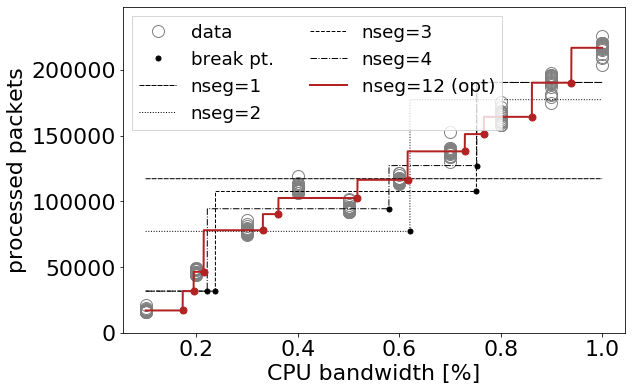

PWLF degree=1
Running optimizer ...
Objective: [0.05253617]
Objective: [0.06253505]
Objective: [0.07753505]
Objective: [0.06039508]
Objective: [0.04253936]
Objective: [0.03767897]
num acquisition: 1, time elapsed: 1.72s
Objective: [0.03321761]
num acquisition: 2, time elapsed: 2.77s
Objective: [0.03321761]
num acquisition: 3, time elapsed: 4.01s
Optimum number of line segments: [3.]
Function value: 0.03321760883876897
PWLF fit: label=1, nseg=1, MAE=9820.227831818178, MSE=134549859.76325107, EVS=0.9617039424635581, R^2=0.9617039424635581
PWLF fit: label=2, nseg=2, MAE=8374.829111687292, MSE=117082707.97173363, EVS=0.9666755050588869, R^2=0.9666755050588869
PWLF fit: label=4, nseg=4, MAE=2573.212074412108, MSE=13704489.475747915, EVS=0.9960993796768405, R^2=0.9960993796768405
PWLF fit: label=5, nseg=5, MAE=2535.0836339534585, MSE=13488901.867073203, EVS=0.9961607409854325, R^2=0.9961607409854325
PWLF fit: label=6, nseg=6, MAE=2534.7846280375643, MSE=13488648.485572927, EVS=0.996160813103

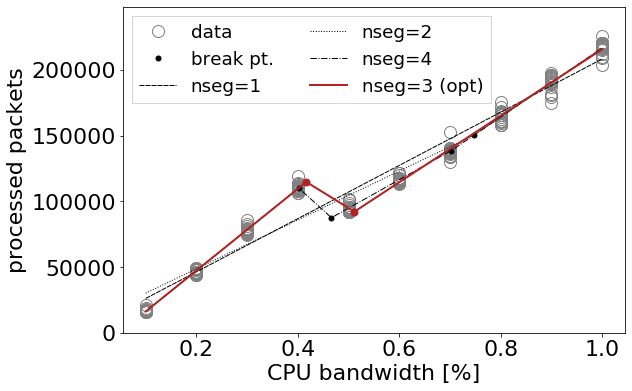

PWLF degree=2
Running optimizer ...
Objective: [0.05253505]
Objective: [0.04253505]
Objective: [0.07753505]
Objective: [0.03753799]
Objective: [0.04753505]
Objective: [0.06009344]
num acquisition: 1, time elapsed: 0.51s
Objective: [0.03267808]
num acquisition: 2, time elapsed: 1.56s
Objective: [0.06253505]
num acquisition: 3, time elapsed: 6.23s
Objective: [0.03266957]
num acquisition: 4, time elapsed: 7.78s
Objective: [0.03267808]
num acquisition: 5, time elapsed: 9.04s
Optimum number of line segments: [3.]
Function value: 0.03266957409258854
PWLF fit: label=1, nseg=1, MAE=9602.084921212108, MSE=133088534.89049351, EVS=0.9621198699234976, R^2=0.9621198699234976
PWLF fit: label=2, nseg=2, MAE=5175.372021307912, MSE=41645731.28907674, EVS=0.9881466444900058, R^2=0.9881466444900058
PWLF fit: label=4, nseg=4, MAE=2538.391258434442, MSE=13482017.200562559, EVS=0.9961627005235939, R^2=0.9961627005235939
PWLF fit: label=5, nseg=5, MAE=2538.3912500002393, MSE=13482017.200562501, EVS=0.9961627

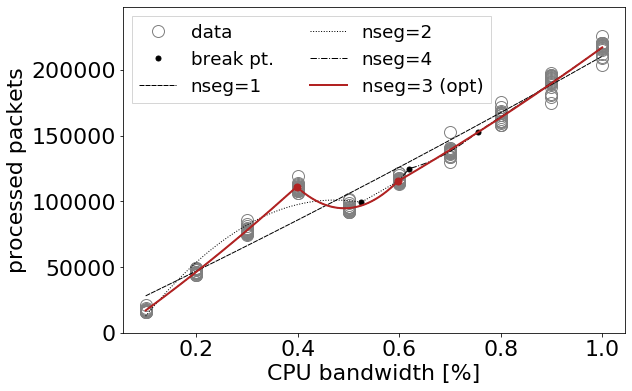

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,48207.509375,3.513413e+09,ds-sec01,1,0.000000
1,0,0.684806,2,28770.821625,1.107407e+09,ds-sec01,2,0.684806
2,0,0.886503,3,17104.771950,3.987633e+08,ds-sec01,3,0.886503
3,0,0.923254,4,14261.381167,2.696415e+08,ds-sec01,4,0.923254
4,0,0.952886,5,11511.221292,1.655323e+08,ds-sec01,5,0.952886
5,0,0.964900,6,9026.696333,1.233190e+08,ds-sec01,6,0.964900
6,0,0.976090,7,7172.738000,8.400608e+07,ds-sec01,7,0.976090
7,0,0.976891,8,7110.699833,8.119012e+07,ds-sec01,8,0.976891
8,0,0.981388,9,5345.200417,6.539105e+07,ds-sec01,9,0.981388
9,0,0.989167,10,4401.795833,3.806071e+07,ds-sec01,10,0.989167


In [28]:
d = select(dfs[0].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec01", x_label="CPU bandwidth [%]", y_label="processed packets")
df_err

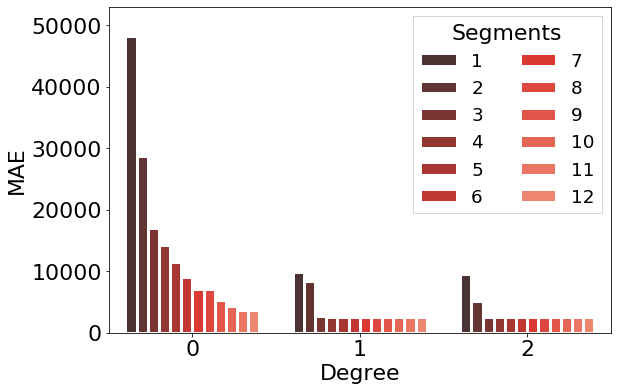

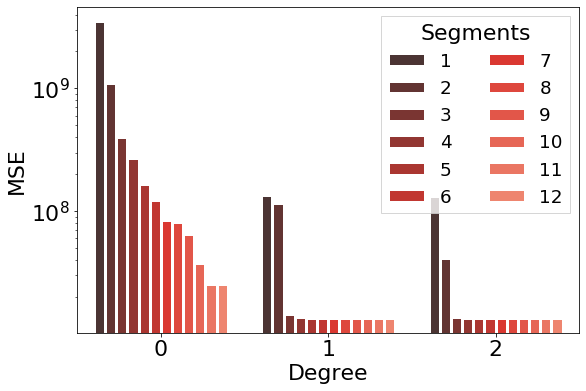

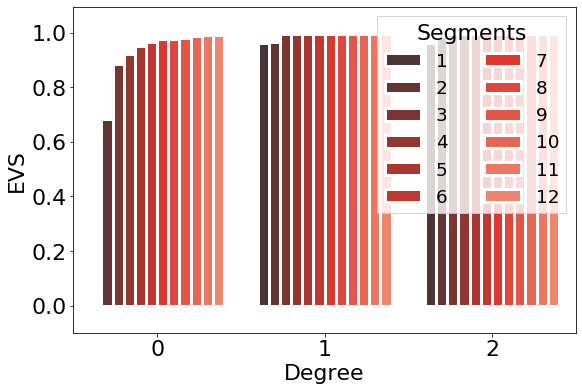

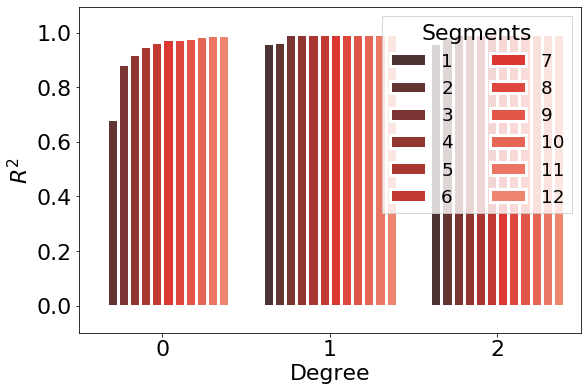

In [29]:
analyse_errors(df_err)

PWLF degree=0
Running optimizer ...
Objective: [0.07365318]
Objective: [0.15236761]
Objective: [0.07865318]
Objective: [0.09157882]
Objective: [0.07776747]
Objective: [0.07657092]
num acquisition: 1, time elapsed: 0.56s
Objective: [0.07635905]
num acquisition: 2, time elapsed: 1.24s
Objective: [0.07157092]
num acquisition: 3, time elapsed: 1.85s
Objective: [0.08259169]
num acquisition: 4, time elapsed: 2.29s
Objective: [0.07137161]
num acquisition: 5, time elapsed: 2.80s
Objective: [0.28128725]
num acquisition: 6, time elapsed: 3.09s
Objective: [0.10939022]
num acquisition: 7, time elapsed: 3.56s
Objective: [0.07598553]
num acquisition: 8, time elapsed: 4.08s
Objective: [0.07157092]
num acquisition: 9, time elapsed: 4.75s
Objective: [0.08135905]
num acquisition: 10, time elapsed: 5.45s
Optimum number of line segments: [9.]
Function value: 0.07137161006879171
PWLF fit: label=1, nseg=1, MAE=10554.207777777778, MSE=153247728.39765432, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=5490.2

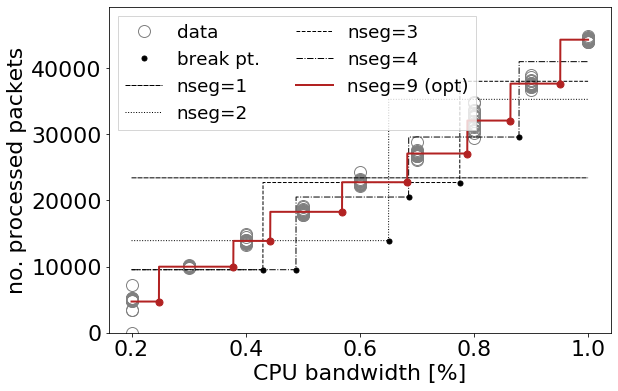

PWLF degree=1
Running optimizer ...
Objective: [0.06657092]
Objective: [0.03205348]
Objective: [0.05672657]
Objective: [0.05667966]
Objective: [0.03672412]
Objective: [0.03042078]
num acquisition: 1, time elapsed: 0.36s
Objective: [0.02740196]
num acquisition: 2, time elapsed: 1.13s
Objective: [0.04680929]
num acquisition: 3, time elapsed: 3.55s
Objective: [0.07657092]
num acquisition: 4, time elapsed: 7.91s
Objective: [0.02740196]
num acquisition: 5, time elapsed: 8.57s
Objective: [0.02740196]
num acquisition: 6, time elapsed: 9.22s
Optimum number of line segments: [2.]
Function value: 0.027401956161065555
PWLF fit: label=1, nseg=1, MAE=909.7511759259249, MSE=1297328.7810698322, EVS=0.9915344338566412, R^2=0.9915344338566412
PWLF fit: label=3, nseg=3, MAE=481.5277220308834, MSE=583846.3385555542, EVS=0.996190179491336, R^2=0.996190179491336
PWLF fit: label=4, nseg=4, MAE=451.52436092709314, MSE=561512.1322430562, EVS=0.9963359187237933, R^2=0.9963359187237933
PWLF fit: label=5, nseg=5

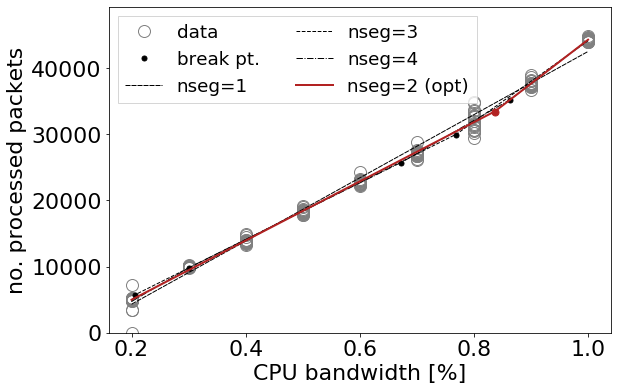

PWLF degree=2
Running optimizer ...
Objective: [0.06657092]
Objective: [0.04157092]
Objective: [0.07657092]
Objective: [0.02708398]
Objective: [0.03657092]
Objective: [0.02490655]
num acquisition: 1, time elapsed: 0.40s
Objective: [0.02490655]
num acquisition: 2, time elapsed: 0.71s
Optimum number of line segments: [1.]
Function value: 0.02490655202913119
PWLF fit: label=2, nseg=2, MAE=479.21169315841206, MSE=585936.5442612213, EVS=0.9961765401002173, R^2=0.9961765401002173
PWLF fit: label=3, nseg=3, MAE=432.1827221924213, MSE=552397.5660555556, EVS=0.9963953947518088, R^2=0.9963953947518088
PWLF fit: label=4, nseg=4, MAE=429.5772222219534, MSE=551271.5658333334, EVS=0.9964027423336229, R^2=0.9964027423336229
PWLF fit: label=5, nseg=5, MAE=429.57722222220264, MSE=551271.5658333334, EVS=0.9964027423336229, R^2=0.9964027423336229
PWLF fit: label=6, nseg=6, MAE=429.57722222223526, MSE=551271.5658333333, EVS=0.9964027423336229, R^2=0.9964027423336229
PWLF fit: label=7, nseg=7, MAE=429.5772

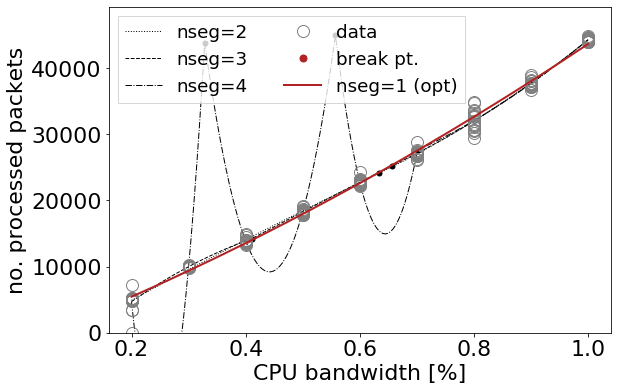

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,10554.207778,1.532477e+08,ds-sec02,1,0.000000
1,0,0.734478,2,5490.287222,4.069066e+07,ds-sec02,2,0.734478
2,0,0.883283,3,3502.040370,1.788654e+07,ds-sec02,3,0.883283
3,0,0.933519,4,2858.742917,1.018803e+07,ds-sec02,4,0.933519
4,0,0.961229,5,2197.430694,5.941596e+06,ds-sec02,5,0.961229
5,0,0.970374,6,1729.004861,4.540159e+06,ds-sec02,6,0.970374
6,0,0.984073,7,1228.213889,2.440804e+06,ds-sec02,7,0.984073
7,0,0.990898,8,821.788333,1.394864e+06,ds-sec02,8,0.990898
8,0,0.996403,10,429.577222,5.512716e+05,ds-sec02,10,0.996403
9,0,0.990892,11,823.718610,1.395792e+06,ds-sec02,11,0.990892


In [14]:
d = select(dfs[1].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec02", x_label="CPU bandwidth [%]", y_label="no. processed packets")
df_err

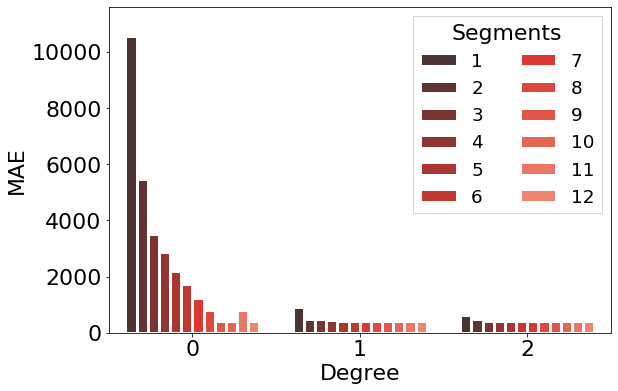

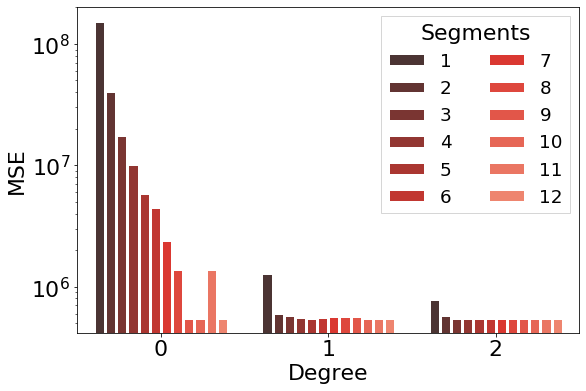

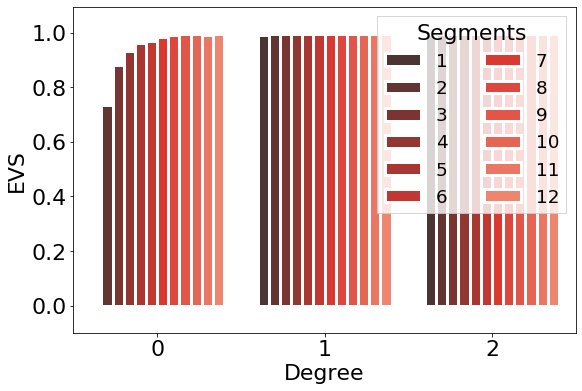

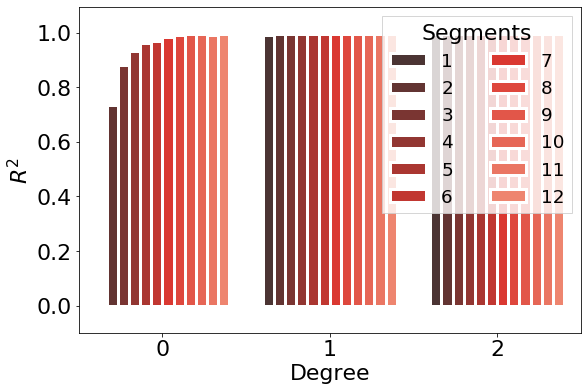

In [15]:
analyse_errors(df_err)

PWLF degree=0
Running optimizer ...
Objective: [0.0787034]
Objective: [0.07649178]
Objective: [0.07632712]
Objective: [0.07981964]
Objective: [0.09619091]
Objective: [0.07382324]
num acquisition: 1, time elapsed: 0.49s
Objective: [0.07891009]
num acquisition: 2, time elapsed: 1.03s
Objective: [0.08393971]
num acquisition: 3, time elapsed: 1.57s
Objective: [0.31451074]
num acquisition: 4, time elapsed: 1.81s
Objective: [0.07826824]
num acquisition: 5, time elapsed: 2.49s
Objective: [0.07454893]
num acquisition: 6, time elapsed: 3.11s
Objective: [0.07418941]
num acquisition: 7, time elapsed: 3.63s
Objective: [0.07328178]
num acquisition: 8, time elapsed: 4.17s
Optimum number of line segments: [8.]
Function value: 0.07328177897672919
PWLF fit: label=1, nseg=1, MAE=9514221.280000003, MSE=119882590359025.36, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=4619495.441100001, MSE=29362183794220.523, EVS=0.7550754975656897, R^2=0.7550754975656897
PWLF fit: label=3, nseg=3, MAE=3077654.73000000

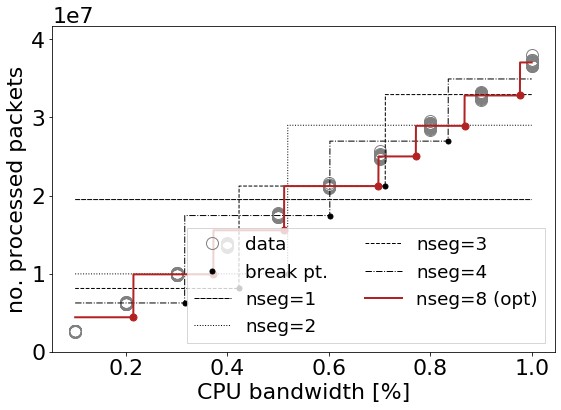

PWLF degree=1
Running optimizer ...
Objective: [0.02020813]
Objective: [0.05511898]
Objective: [0.06511894]
Objective: [0.01241348]
Objective: [0.02020813]
Objective: [0.01241348]
num acquisition: 1, time elapsed: 0.23s
Objective: [0.01241348]
num acquisition: 2, time elapsed: 0.45s
Optimum number of line segments: [1.]
Function value: 0.012413478676431236
PWLF fit: label=2, nseg=2, MAE=138436.5136780459, MSE=37452225993.22114, EVS=0.999687592452907, R^2=0.999687592452907
PWLF fit: label=3, nseg=3, MAE=123929.02947756517, MSE=33944390568.79205, EVS=0.9997168530437395, R^2=0.9997168530437395
PWLF fit: label=4, nseg=4, MAE=119550.35268606436, MSE=32819775226.63374, EVS=0.9997262340167297, R^2=0.9997262340167297
PWLF fit: label=5, nseg=5, MAE=119500.71959854059, MSE=32804994568.8667, EVS=0.9997263573095091, R^2=0.9997263573095091
PWLF fit: label=6, nseg=6, MAE=119448.06296172125, MSE=32793918235.836166, EVS=0.9997264497026831, R^2=0.9997264497026831
PWLF fit: label=7, nseg=7, MAE=119349.6

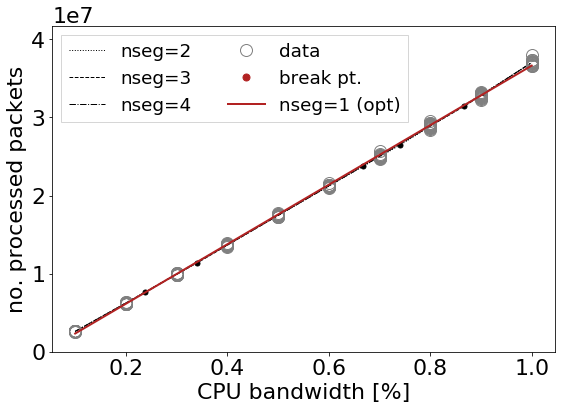

PWLF degree=2
Running optimizer ...
Objective: [0.06011894]
Objective: [0.01037864]
Objective: [0.03011894]
Objective: [0.05011894]
Objective: [0.06011894]
Objective: [0.01037864]
num acquisition: 1, time elapsed: 0.34s
Objective: [0.01037864]
num acquisition: 2, time elapsed: 0.66s
Optimum number of line segments: [1.]
Function value: 0.010378639173202489
PWLF fit: label=2, nseg=2, MAE=121922.85138690492, MSE=33210439846.120365, EVS=0.999722975289851, R^2=0.999722975289851
PWLF fit: label=3, nseg=3, MAE=119390.78886676027, MSE=32851605938.046806, EVS=0.999725968501017, R^2=0.999725968501017
PWLF fit: label=4, nseg=4, MAE=119349.68212796125, MSE=32791711154.873505, EVS=0.9997264681130373, R^2=0.9997264681130373
PWLF fit: label=5, nseg=5, MAE=119349.68200000204, MSE=32791711154.8735, EVS=0.9997264681130373, R^2=0.9997264681130373
PWLF fit: label=6, nseg=6, MAE=119349.68199999962, MSE=32791711154.8735, EVS=0.9997264681130373, R^2=0.9997264681130373
PWLF fit: label=7, nseg=7, MAE=119349.6

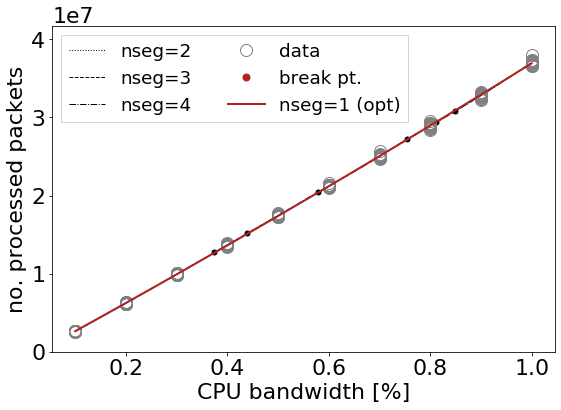

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,9.514221e+06,1.198826e+14,ds-sec03,1,0.000000
1,0,0.755075,2,4.619495e+06,2.936218e+13,ds-sec03,2,0.755075
2,0,0.891611,3,3.077655e+06,1.299390e+13,ds-sec03,3,0.891611
3,0,0.940038,4,2.311077e+06,7.188349e+12,ds-sec03,4,0.940038
4,0,0.958214,5,1.932502e+06,5.009440e+12,ds-sec03,5,0.958214
5,0,0.976118,6,1.536039e+06,2.863052e+12,ds-sec03,6,0.976118
6,0,0.982456,7,1.184898e+06,2.103228e+12,ds-sec03,7,0.982456
7,0,0.988058,9,8.385761e+05,1.431644e+12,ds-sec03,9,0.988058
8,0,0.993424,10,4.659348e+05,7.882900e+11,ds-sec03,10,0.993424
9,0,0.994017,11,4.796478e+05,7.172036e+11,ds-sec03,11,0.994017


In [16]:
d = select(dfs[2].copy(), {"flow_size": 0, "ruleset": 0, "memory": 256})
df_err = analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec03", x_label="CPU bandwidth [%]", y_label="no. processed packets")
df_err

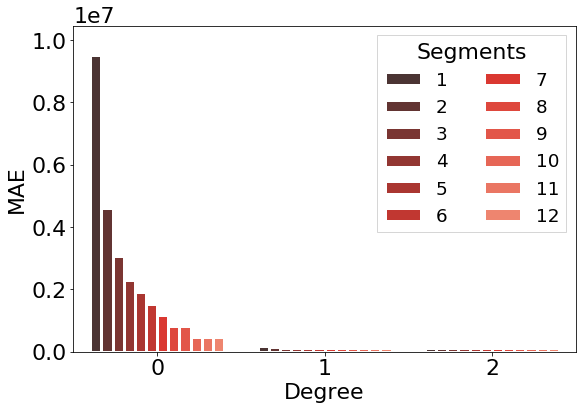

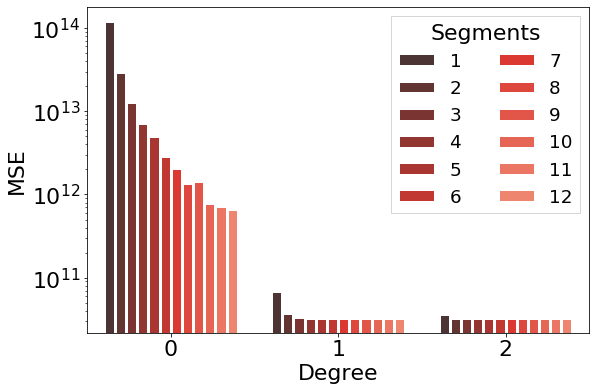

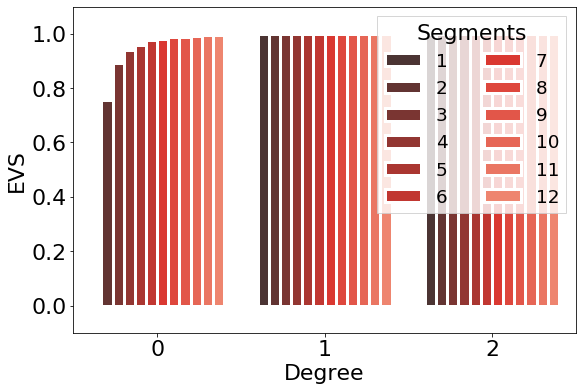

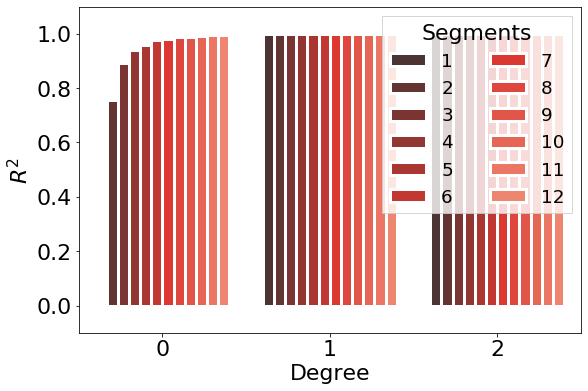

In [17]:
analyse_errors(df_err)

PWLF degree=0
Running optimizer ...
Objective: [0.06041713]
Objective: [0.0655204]
Objective: [0.0556639]
Objective: [0.0408224]
Objective: [0.05050074]
Objective: [0.32947031]
num acquisition: 1, time elapsed: 0.35s
Objective: [0.04588911]
num acquisition: 2, time elapsed: 0.91s
Objective: [0.03805319]
num acquisition: 3, time elapsed: 1.56s
Objective: [0.07039783]
num acquisition: 4, time elapsed: 2.18s
Objective: [0.08779006]
num acquisition: 5, time elapsed: 2.59s
Objective: [0.0360652]
num acquisition: 6, time elapsed: 2.97s
Objective: [0.03767306]
num acquisition: 7, time elapsed: 3.39s
Optimum number of line segments: [5.]
Function value: 0.03606519945070643
PWLF fit: label=1, nseg=1, MAE=1613.9431605262491, MSE=3822958.056145148, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=524.2929572390235, MSE=505551.75453253684, EVS=0.8677590109261344, R^2=0.8677590109261344
PWLF fit: label=3, nseg=3, MAE=251.79894020462015, MSE=180995.31194584884, EVS=0.952655689838158, R^2=0.9526556898

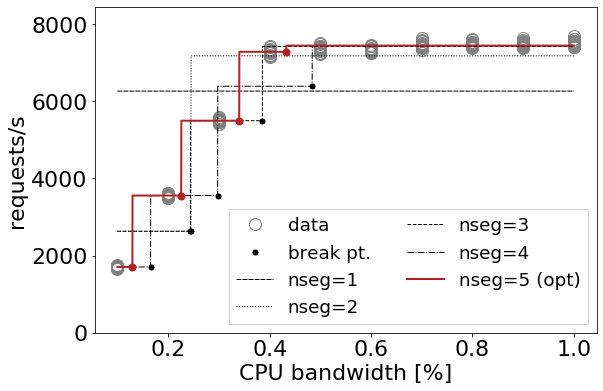

PWLF degree=1
Running optimizer ...
Objective: [0.02601663]
Objective: [0.0653973]
Objective: [0.0554335]
Objective: [0.0604346]
Objective: [0.04042107]
Objective: [0.19699784]
num acquisition: 1, time elapsed: 0.36s
Objective: [0.03078256]
num acquisition: 2, time elapsed: 2.31s
Objective: [0.04542806]
num acquisition: 3, time elapsed: 5.83s
Objective: [0.03559593]
num acquisition: 4, time elapsed: 8.04s
Objective: [0.0703973]
num acquisition: 5, time elapsed: 14.54s
Objective: [0.0503973]
num acquisition: 6, time elapsed: 18.17s
Objective: [0.0211845]
num acquisition: 7, time elapsed: 18.92s
Objective: [0.0211845]
num acquisition: 8, time elapsed: 19.68s
Optimum number of line segments: [2.]
Function value: 0.021184496468961044
PWLF fit: label=1, nseg=1, MAE=992.8535639653711, MSE=1338573.6513355207, EVS=0.6498591845171167, R^2=0.6498591845171167
PWLF fit: label=3, nseg=3, MAE=53.421296307340036, MSE=4407.037886484611, EVS=0.9988472178292931, R^2=0.9988472178292931
PWLF fit: label=4,

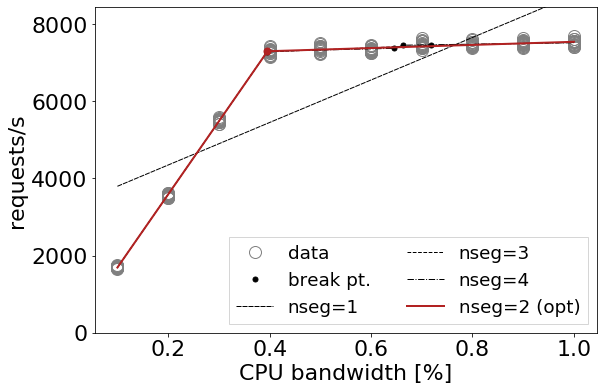

PWLF degree=2
Running optimizer ...
Objective: [0.0819012]
Objective: [0.0603973]
Objective: [0.0453973]
Objective: [0.0819012]
Objective: [0.0303973]
Objective: [0.0303973]
num acquisition: 1, time elapsed: 2.30s
Optimum number of line segments: [4.]
Function value: 0.030397300336548243
PWLF fit: label=1, nseg=1, MAE=396.9745002193729, MSE=214741.44701872306, EVS=0.94382845852218, R^2=0.9438284585221801
PWLF fit: label=2, nseg=2, MAE=51.6093235163395, MSE=4313.181050514802, EVS=0.9988717686704457, R^2=0.9988717686704457
PWLF fit: label=3, nseg=3, MAE=50.133914220681035, MSE=4091.6859307972863, EVS=0.998929706821078, R^2=0.998929706821078
PWLF fit: label=5, nseg=5, MAE=49.335961394396485, MSE=3926.570045420479, EVS=0.9989730100988686, R^2=0.998972897429751
PWLF fit: label=6, nseg=6, MAE=49.326655382111035, MSE=3925.462063454355, EVS=0.9989731872529586, R^2=0.9989731872529586
PWLF fit: label=7, nseg=7, MAE=49.32671937966762, MSE=3925.457987766446, EVS=0.9989731899358348, R^2=0.998973188

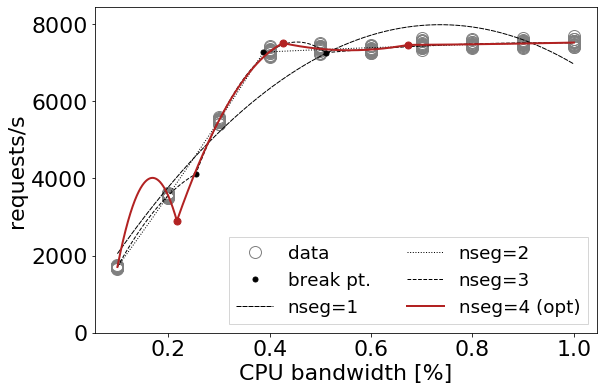

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,1613.943161,3.822958e+06,ds-web01,1,0.000000
1,0,0.867759,2,524.292957,5.055518e+05,ds-web01,2,0.867759
2,0,0.952656,3,251.798940,1.809953e+05,ds-web01,3,0.952656
3,0,0.956350,4,230.935218,1.668713e+05,ds-web01,4,0.956350
4,0,0.998888,6,50.424692,4.253014e+03,ds-web01,6,0.998888
5,0,0.998888,7,50.424692,4.253014e+03,ds-web01,7,0.998888
6,0,0.998967,8,49.588735,3.950966e+03,ds-web01,8,0.998967
7,0,0.998920,9,51.272590,4.129351e+03,ds-web01,9,0.998920
8,0,0.998939,10,51.000673,4.057049e+03,ds-web01,10,0.998939
9,0,0.998973,11,49.298334,3.925861e+03,ds-web01,11,0.998973


In [26]:
d = select(dfs[3].copy(), {"req_size": 0, "memory": 64})
df_err = analyse_fits(d, "cpu_bw", "req_per_sec", name="ds-web01", x_label="CPU bandwidth [%]", y_label="requests/s")
df_err

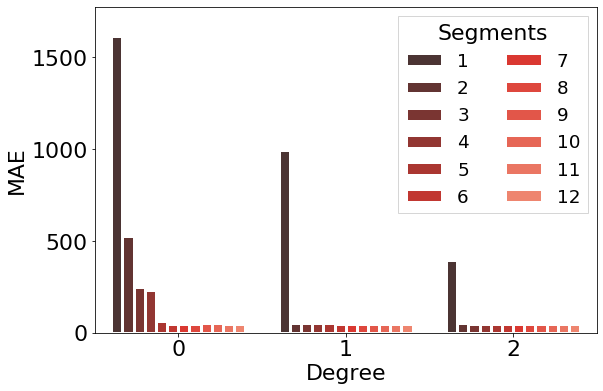

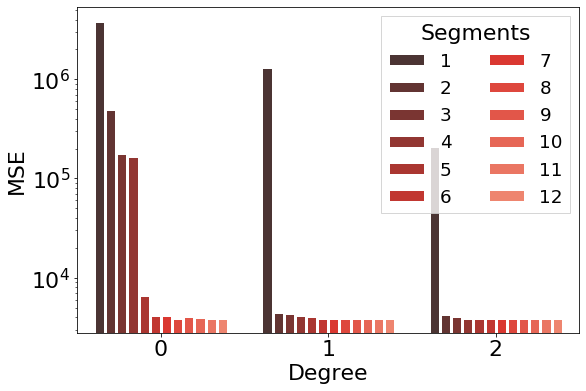

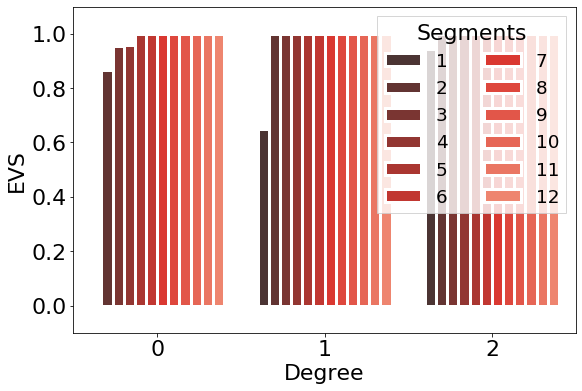

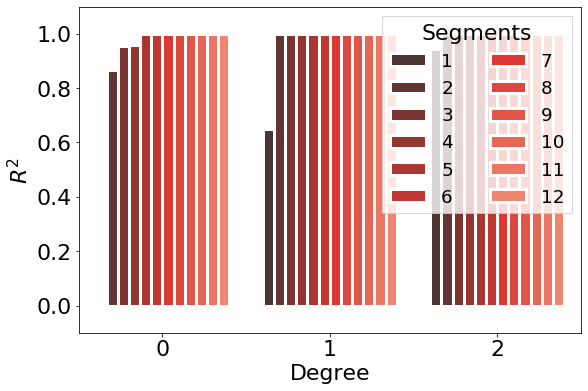

In [27]:
analyse_errors(df_err)

PWLF degree=0
Running optimizer ...
Objective: [0.14106999]
Objective: [0.09213592]
Objective: [0.07451053]
Objective: [0.0669269]
Objective: [0.14106999]
Objective: [0.37859854]
num acquisition: 1, time elapsed: 0.31s
Objective: [0.09668959]
num acquisition: 2, time elapsed: 0.64s
Objective: [0.06692103]
num acquisition: 3, time elapsed: 1.26s
Objective: [0.0619425]
num acquisition: 4, time elapsed: 1.79s
Objective: [0.05696058]
num acquisition: 5, time elapsed: 2.22s
Objective: [0.06451742]
num acquisition: 6, time elapsed: 2.64s
Objective: [0.07192103]
num acquisition: 7, time elapsed: 3.16s
Objective: [0.06951873]
num acquisition: 8, time elapsed: 3.61s
Objective: [0.08207217]
num acquisition: 9, time elapsed: 4.02s
Objective: [0.07950903]
num acquisition: 10, time elapsed: 4.52s
Objective: [0.0619269]
num acquisition: 11, time elapsed: 5.02s
Objective: [0.06194252]
num acquisition: 12, time elapsed: 5.50s
Optimum number of line segments: [9.]
Function value: 0.05696057687853333
PW

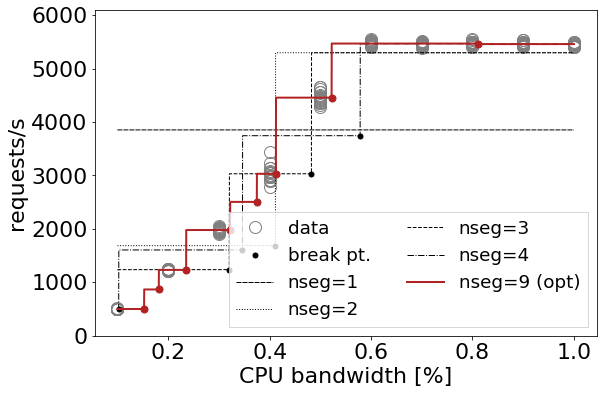

PWLF degree=1
Running optimizer ...
Objective: [0.05192103]
Objective: [0.06692103]
Objective: [0.04692103]
Objective: [0.04692664]
Objective: [0.05692103]
Objective: [0.15034742]
num acquisition: 1, time elapsed: 0.49s
Objective: [0.04192215]
num acquisition: 2, time elapsed: 3.54s
Objective: [0.03692776]
num acquisition: 3, time elapsed: 5.69s
Objective: [0.03694922]
num acquisition: 4, time elapsed: 8.24s
Optimum number of line segments: [5.]
Function value: 0.036927762100297724
PWLF fit: label=1, nseg=1, MAE=626.2355744242423, MSE=539879.0527087103, EVS=0.8486423738670795, R^2=0.8486423738670795
PWLF fit: label=2, nseg=2, MAE=125.70580207794701, MSE=30330.522858826957, EVS=0.9914966955723706, R^2=0.9914966955723706
PWLF fit: label=3, nseg=3, MAE=35.828916417138196, MSE=3661.492101861769, EVS=0.9989734835054969, R^2=0.9989734835054969
PWLF fit: label=4, nseg=4, MAE=35.847176625588475, MSE=3651.9546368292918, EVS=0.9989761573785789, R^2=0.9989761573785789
PWLF fit: label=6, nseg=6, M

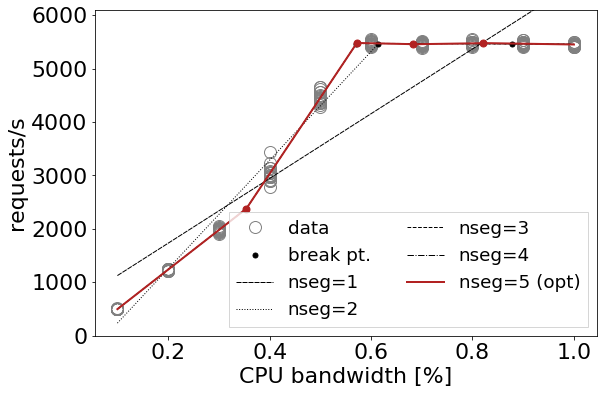

PWLF degree=2
Running optimizer ...
Objective: [0.04192103]
Objective: [0.03192103]
Objective: [0.02695798]
Objective: [0.07360834]
Objective: [0.06192103]
Objective: [0.03692106]
num acquisition: 1, time elapsed: 1.77s
Objective: [0.07192103]
num acquisition: 2, time elapsed: 12.45s
Objective: [0.05192103]
num acquisition: 3, time elapsed: 16.52s
Objective: [0.04692103]
num acquisition: 4, time elapsed: 19.86s
Objective: [0.0239962]
num acquisition: 5, time elapsed: 20.56s
Objective: [0.05692103]
num acquisition: 6, time elapsed: 25.95s
Objective: [0.06692103]
num acquisition: 7, time elapsed: 34.67s
Objective: [0.0239962]
num acquisition: 8, time elapsed: 35.39s
Objective: [0.0239962]
num acquisition: 9, time elapsed: 35.96s
Optimum number of line segments: [2.]
Function value: 0.02399620049233341
PWLF fit: label=1, nseg=1, MAE=281.0705138409081, MSE=120291.70544277801, EVS=0.9662756558381921, R^2=0.9662756558381921
PWLF fit: label=3, nseg=3, MAE=35.751713438594145, MSE=3654.24347553

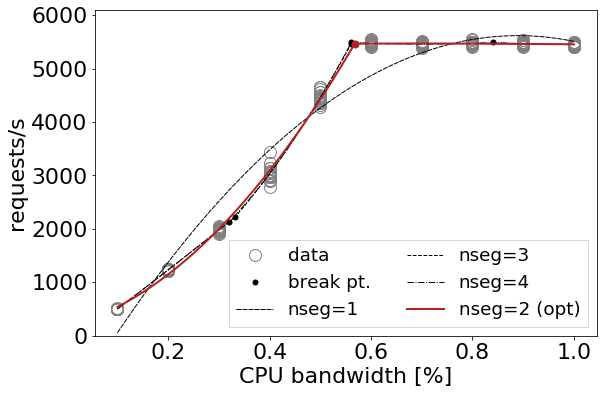

,degree,evs,label,mae,mse,name,nseg,r2
0,0,1.110223e-16,1,1732.850420,3.566910e+06,ds-web02,1,0.000000
1,0,8.769175e-01,2,495.717883,4.390241e+05,ds-web02,2,0.876918
2,0,9.445980e-01,3,326.504635,1.976140e+05,ds-web02,3,0.944598
3,0,9.627186e-01,4,230.916994,1.329796e+05,ds-web02,4,0.962719
4,0,9.759294e-01,5,200.508638,8.585751e+04,ds-web02,5,0.975929
5,0,9.912716e-01,6,108.721350,3.113444e+04,ds-web02,6,0.991271
6,0,9.989740e-01,7,35.688878,3.659592e+03,ds-web02,7,0.998974
7,0,9.989769e-01,8,35.721461,3.649169e+03,ds-web02,8,0.998977
8,0,9.989782e-01,10,35.809585,3.644791e+03,ds-web02,10,0.998978
9,0,9.989808e-01,11,35.877438,3.635271e+03,ds-web02,11,0.998981


In [20]:
d = select(dfs[4].copy(), {"req_size": 0, "memory": 64})
df_err = analyse_fits(d, "cpu_bw", "req_per_sec", name="ds-web02", x_label="CPU bandwidth [%]", y_label="requests/s")
df_err

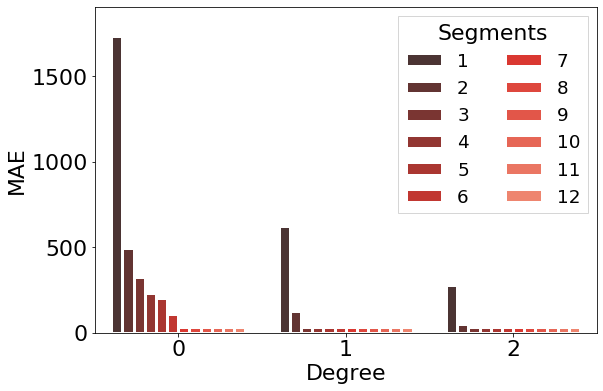

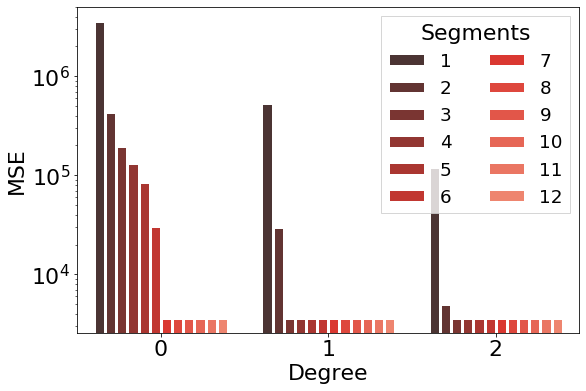

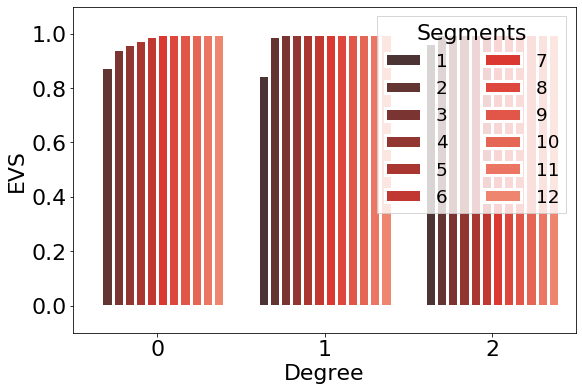

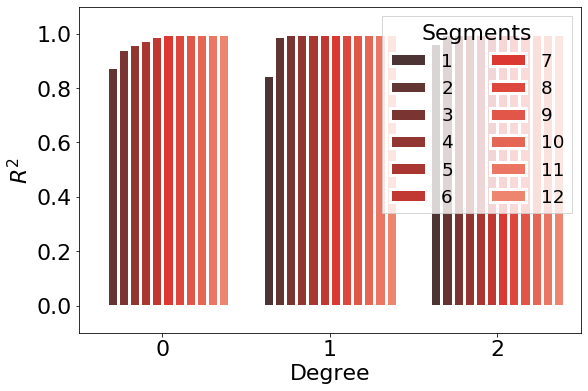

In [21]:
analyse_errors(df_err)

PWLF degree=0
Running optimizer ...
Objective: [0.35074764]
Objective: [0.0758914]
Objective: [0.08577932]
Objective: [0.07549157]
Objective: [0.07183079]
Objective: [0.07683057]
num acquisition: 1, time elapsed: 0.54s
Objective: [0.06184198]
num acquisition: 2, time elapsed: 1.08s
Objective: [0.07812029]
num acquisition: 3, time elapsed: 1.56s
Objective: [0.07212022]
num acquisition: 4, time elapsed: 2.12s
Objective: [0.08079312]
num acquisition: 5, time elapsed: 2.81s
Objective: [0.08504743]
num acquisition: 6, time elapsed: 3.28s
Objective: [0.10783867]
num acquisition: 7, time elapsed: 3.68s
Objective: [0.08549157]
num acquisition: 8, time elapsed: 4.21s
Objective: [0.07142906]
num acquisition: 9, time elapsed: 4.72s
Objective: [0.08581859]
num acquisition: 10, time elapsed: 5.23s
Optimum number of line segments: [9.]
Function value: 0.06184198222960379
PWLF fit: label=1, nseg=1, MAE=1560.76724, MSE=3085225.52279896, EVS=0.0, R^2=0.0
PWLF fit: label=2, nseg=2, MAE=612.6625083333338

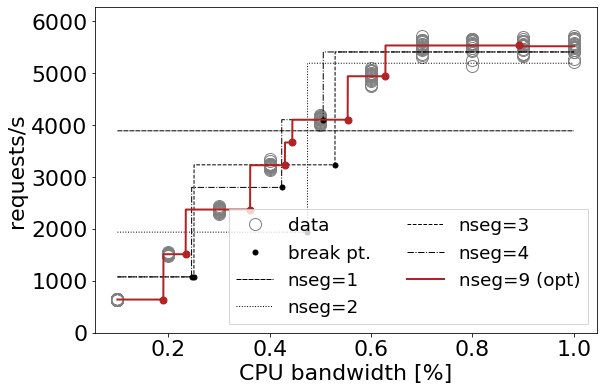

PWLF degree=1
Running optimizer ...
Objective: [0.06183057]
Objective: [0.07183057]
Objective: [0.06183057]
Objective: [0.07683057]
Objective: [0.03187144]
Objective: [0.11692756]
num acquisition: 1, time elapsed: 0.50s
Objective: [0.03185439]
num acquisition: 2, time elapsed: 1.76s
Objective: [0.03187144]
num acquisition: 3, time elapsed: 2.93s
Optimum number of line segments: [3.]
Function value: 0.03185439354202592
PWLF fit: label=1, nseg=1, MAE=490.82164236363633, MSE=323327.4301824726, EVS=0.8952013628199389, R^2=0.8952013628199389
PWLF fit: label=2, nseg=2, MAE=58.61474828971297, MSE=7372.074157876912, EVS=0.9976105234112063, R^2=0.9976105234112063
PWLF fit: label=4, nseg=4, MAE=57.81832414900116, MSE=7327.112508024201, EVS=0.997625096624581, R^2=0.997625096624581
PWLF fit: label=5, nseg=5, MAE=57.62095214107557, MSE=7317.589143354199, EVS=0.9976281833890978, R^2=0.9976281833890978
PWLF fit: label=6, nseg=6, MAE=57.83271203782593, MSE=7321.104388320038, EVS=0.9976270440088677, R^

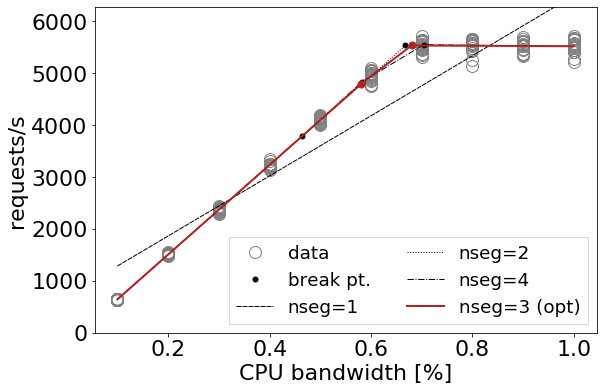

PWLF degree=2
Running optimizer ...
Objective: [0.06183057]
Objective: [0.02687569]
Objective: [0.06183057]
Objective: [0.04183057]
Objective: [0.04683057]
Objective: [0.04444613]
num acquisition: 1, time elapsed: 0.60s
Objective: [0.02687569]
num acquisition: 2, time elapsed: 1.54s
Objective: [0.03184727]
num acquisition: 3, time elapsed: 2.63s
Objective: [0.07683057]
num acquisition: 4, time elapsed: 13.91s
Objective: [0.03683057]
num acquisition: 5, time elapsed: 15.56s
Objective: [0.05183057]
num acquisition: 6, time elapsed: 19.05s
Objective: [0.06683057]
num acquisition: 7, time elapsed: 25.10s
Objective: [0.02687569]
num acquisition: 8, time elapsed: 25.83s
Objective: [0.05683057]
num acquisition: 9, time elapsed: 30.04s
Objective: [0.02687569]
num acquisition: 10, time elapsed: 30.68s
Objective: [0.02687569]
num acquisition: 11, time elapsed: 31.25s
Optimum number of line segments: [2.]
Function value: 0.026875690848208664
PWLF fit: label=1, nseg=1, MAE=169.7263306666659, MSE=4

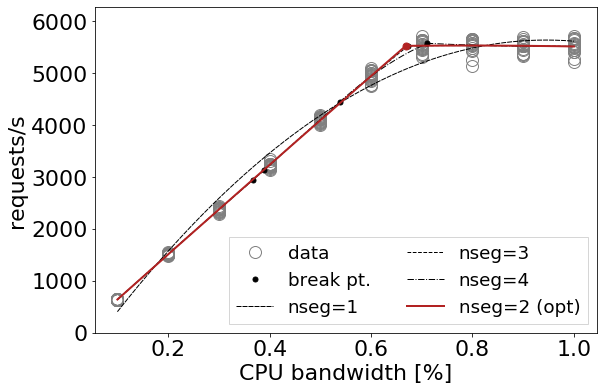

,degree,evs,label,mae,mse,name,nseg,r2
0,0,0.000000,1,1560.767240,3.085226e+06,ds-web03,1,0.000000
1,0,0.822466,2,612.662508,5.477314e+05,ds-web03,2,0.822466
2,0,0.927899,3,369.321297,2.224469e+05,ds-web03,3,0.927899
3,0,0.964605,4,282.845232,1.092015e+05,ds-web03,4,0.964605
4,0,0.965901,5,277.229467,1.052034e+05,ds-web03,5,0.965901
5,0,0.979604,6,179.263582,6.292738e+04,ds-web03,6,0.979604
6,0,0.985159,7,137.896265,4.578780e+04,ds-web03,7,0.985159
7,0,0.986292,8,128.590785,4.229296e+04,ds-web03,8,0.986292
8,0,0.997630,10,57.567160,7.311011e+03,ds-web03,10,0.997630
9,0,0.997627,11,57.793215,7.320546e+03,ds-web03,11,0.997627


In [22]:
d = select(dfs[5].copy(), {"req_size": 0, "memory": 64})
df_err = analyse_fits(d, "cpu_bw", "req_per_sec", name="ds-web03", x_label="CPU bandwidth [%]", y_label="requests/s")
df_err

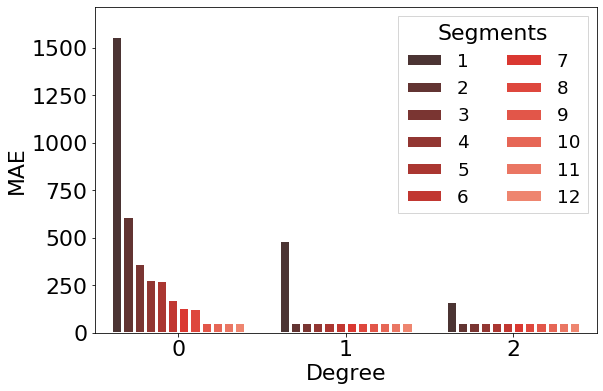

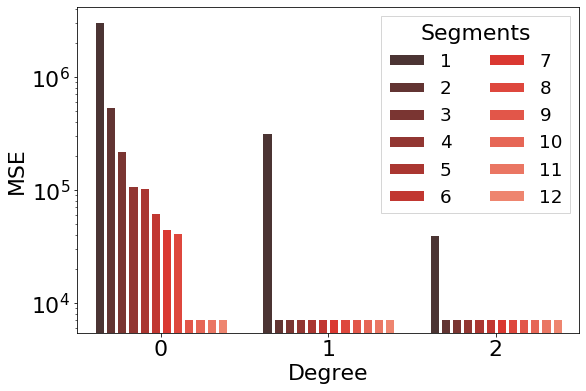

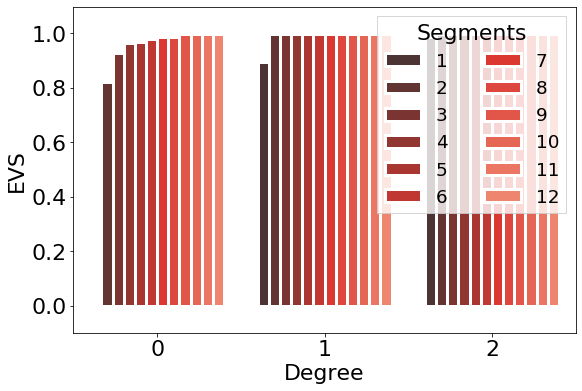

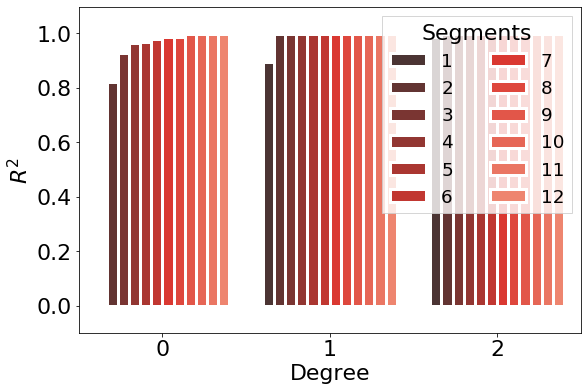

In [23]:
analyse_errors(df_err)